In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np


In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = CustomDataset(csv_file='mnist_train.csv', transform=transform)
test_dataset = CustomDataset(csv_file='mnist_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(4*4*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 4*4*64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (optional)
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Uncomment to train the model
train_model(model, train_loader, criterion, optimizer)
# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')

# Load pre-trained model
model.load_state_dict(torch.load('mnist_cnn.pth'))
model.eval()


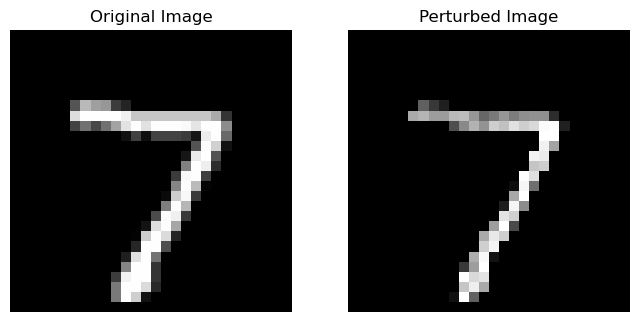

In [20]:
import torch
import numpy as np

def deepfool_attack(image, model, num_classes=10, max_iter=100, epsilon=1e-3):
    image = image.clone().detach().requires_grad_(True)
    perturbed_image = image.clone()

    # Forward pass to get the initial prediction
    output = model(perturbed_image)
    _, init_pred = torch.max(output, 1)
    perturbed_image.requires_grad_(True)  # Ensure requires_grad is set to True

    # Initialize perturbation and iteration counter
    r_tot = torch.zeros_like(image)

    for iter_count in range(max_iter):
        # Calculate gradients
        output = model(perturbed_image)
        _, pred_label = torch.max(output, 1)
        grad_orig = torch.autograd.grad(output[0, init_pred.item()], perturbed_image, create_graph=True)[0]

        # Check if the prediction is different from initial prediction
        if pred_label != init_pred.item():
            break

        # Calculate perturbation
        min_perturbation = np.inf
        for k in range(num_classes):
            if k != init_pred.item():
                grad_curr = torch.autograd.grad(output[0, k], perturbed_image, create_graph=True)[0]
                w_k = grad_curr - grad_orig
                f_k = output[0, k] - output[0, init_pred.item()]
                pert_k = abs(f_k) / torch.norm(w_k.flatten(), p=2)
                if pert_k < min_perturbation:
                    min_perturbation = pert_k
                    r_i = pert_k * w_k / torch.norm(w_k, p=2)

        # Add perturbation to the image
        r_tot += r_i
        perturbed_image = image + (1 + epsilon) * r_tot
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        # Detach perturbed_image to prevent further gradient tracking
        perturbed_image = perturbed_image.detach().requires_grad_(True)

    return perturbed_image

# Example usage
# Assuming `model` is your trained CNN model
model.eval()  # Set model to evaluation mode

# Select a test image and its label
test_image, test_label = next(iter(test_loader))

# Perform DeepFool attack
perturbed_image = deepfool_attack(test_image, model)

# Display original and perturbed images
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(perturbed_image.squeeze().detach().numpy(), cmap='gray')
plt.title('Perturbed Image')
plt.axis('off')

plt.show()


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (correct / total) * 100
    return accuracy

# Example usage
model.eval()  # Set model to evaluation mode

# Calculate accuracy on original test images
accuracy_original = calculate_accuracy(model, test_loader)
print(f'Accuracy on original test images: {accuracy_original:.2f}%')

# Apply DeepFool attack on a batch of test images
test_images, test_labels = next(iter(test_loader))
perturbed_images = deepfool_attack(test_images, model)

# Calculate accuracy on perturbed test images
accuracy_perturbed = calculate_accuracy(model, [(perturbed_images, test_labels)])
print(f'Accuracy on perturbed test images: {accuracy_perturbed:.2f}%')

Accuracy on original test images: 97.90%
Accuracy on perturbed test images: 100.00%


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Define the model (example CNN architecture)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Function to perform DeepFool attack
def deepfool_attack(image, model, num_classes=10, max_iter=100, epsilon=1e-3):
    image = image.clone().detach().requires_grad_(True)
    perturbed_image = image.clone()

    # Forward pass to get the initial prediction
    output = model(perturbed_image)
    _, init_pred = torch.max(output, 1)
    perturbed_image.requires_grad_(True)  # Ensure requires_grad is set to True

    # Initialize perturbation and iteration counter
    r_tot = torch.zeros_like(image)

    for iter_count in range(max_iter):
        # Calculate gradients
        output = model(perturbed_image)
        _, pred_label = torch.max(output, 1)
        grad_orig = torch.autograd.grad(output[0, init_pred.item()], perturbed_image, create_graph=True)[0]

        # Check if the prediction is different from initial prediction
        if pred_label != init_pred.item():
            break

        # Calculate perturbation
        min_perturbation = np.inf
        for k in range(num_classes):
            if k != init_pred.item():
                grad_curr = torch.autograd.grad(output[0, k], perturbed_image, create_graph=True)[0]
                w_k = grad_curr - grad_orig
                f_k = output[0, k] - output[0, init_pred.item()]
                pert_k = abs(f_k) / torch.norm(w_k.flatten(), p=2)
                if pert_k < min_perturbation:
                    min_perturbation = pert_k
                    r_i = pert_k * w_k / torch.norm(w_k, p=2)

        # Add perturbation to the image
        r_tot += r_i
        perturbed_image = image + (1 + epsilon) * r_tot
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        # Detach perturbed_image to prevent further gradient tracking
        perturbed_image = perturbed_image.detach().requires_grad_(True)

    return perturbed_image
    

# Function to perform adversarial training
def adversarial_training(model, train_loader, test_loader, num_epochs=10, eps=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Generate adversarial examples using DeepFool attack
            adversarial_images = deepfool_attack(images, model)

            # Compute predictions and loss for both original and adversarial examples
            outputs_orig = model(images)
            loss_orig = criterion(outputs_orig, labels)
            outputs_adv = model(adversarial_images)
            loss_adv = criterion(outputs_adv, labels)

            # Total loss combines loss from original and adversarial examples
            total_loss = loss_orig + loss_adv

            # Backward propagation and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Evaluate model accuracy on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = (correct / total) * 100
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')



    # Initialize the model
    model = CNN()

    # Perform adversarial training
    adversarial_training(model, train_loader, test_loader)
